## Capstone Project: Create a Customer Segmentation Report for Arvato Financial Services - Book2


In [328]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#from sklearn.preprocessing import Imputer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.metrics import roc_auc_score, roc_curve, plot_roc_curve, accuracy_score
from sklearn.model_selection import train_test_split,  GridSearchCV

# magic word for producing visualizations in notebook
%matplotlib inline

## Part 1: 

Customer Segmentation Report
The main bulk of your analysis will come in this part of the project. Here, you should use unsupervised learning techniques to describe the relationship between the demographics of the company's existing customers and the general population of Germany. By the end of this part, you should be able to describe parts of the general population that are more likely to be part of the mail-order company's main customer base, and which parts of the general population are less so.

In [329]:
# Reading the cleaned datasets 
azdias_go_ = pd.read_csv('azdias_go.csv', low_memory=False)
azdias_go_.drop(['Unnamed: 0'], axis=1, inplace=True)
azdias_go_.head()

,AKT_DAT_KL,ALTER_HH,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_TITEL,ARBEIT,BALLRAUM,CJT_KATALOGNUTZER,...,ZABEOTYP_1,ZABEOTYP_2,ZABEOTYP_3,ZABEOTYP_4,ZABEOTYP_5,ZABEOTYP_6,CAMEO_wealth,CAMEO_life,PR_J_mvt,PR_J_gen
0,9.0,0.0,11.0,0.0,0.0,2.0,0.0,3.0,6.0,1.0,...,0,0,0,0,1,0,51.0,51.0,0,7
1,9.0,17.0,10.0,0.0,0.0,1.0,0.0,3.0,2.0,2.0,...,0,0,0,0,1,0,24.0,24.0,1,7
2,1.0,13.0,1.0,0.0,0.0,0.0,0.0,2.0,4.0,3.0,...,0,0,1,0,0,0,12.0,12.0,0,4
3,1.0,20.0,3.0,0.0,0.0,4.0,0.0,4.0,2.0,3.0,...,0,0,0,1,0,0,43.0,43.0,0,4
4,1.0,10.0,5.0,0.0,0.0,1.0,0.0,2.0,6.0,5.0,...,0,0,0,1,0,0,54.0,54.0,0,2


In [330]:
azdias_go_.shape

(644077, 490)

In [331]:
customers_go_ = pd.read_csv('customers_go.csv', low_memory=False)
customers_go_.drop(['Unnamed: 0'], axis=1, inplace=True)
customers_go_.head()

,AKT_DAT_KL,ALTER_HH,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_TITEL,ARBEIT,BALLRAUM,CJT_KATALOGNUTZER,...,ZABEOTYP_4,ZABEOTYP_5,ZABEOTYP_6,PRODUCT_GROUP_1,PRODUCT_GROUP_2,PRODUCT_GROUP_3,CAMEO_wealth,CAMEO_life,PR_J_mvt,PR_J_gen
0,1.0,10.0,1.0,0.0,0.0,2.0,0.0,1.0,3.0,4.0,...,0,0,0,0,0,1,13.0,13.0,1,2
1,9.0,11.0,NaN,NaN,0.0,3.0,0.0,NaN,NaN,NaN,...,0,0,0,0,1,0,NaN,NaN,0,0
2,1.0,6.0,1.0,0.0,0.0,1.0,0.0,3.0,7.0,5.0,...,0,0,0,0,0,1,34.0,34.0,1,2
3,1.0,8.0,0.0,NaN,0.0,0.0,0.0,1.0,7.0,5.0,...,0,0,0,1,0,0,24.0,24.0,0,1
4,1.0,20.0,7.0,0.0,0.0,4.0,0.0,3.0,3.0,4.0,...,0,0,0,0,1,0,41.0,41.0,0,4


In [332]:
customers_go_.shape

(191652, 494)

Find out differences in the columns of `azdias_go_` and `customers_go_`

In [333]:
delta1 = np.setdiff1d(list(azdias_go_.columns), list(customers_go_.columns))

In [334]:
print(delta1)

['TITEL_KZ_2.0']


In [335]:
delta2 = np.setdiff1d(list(customers_go_.columns), list(azdias_go_.columns))
print(delta2)

['CUSTOMER_GROUP' 'ONLINE_PURCHASE' 'PRODUCT_GROUP_1' 'PRODUCT_GROUP_2'
 'PRODUCT_GROUP_3']


The five extra columns in the customers data set come from the three features present in the original customers file and not included in the demographic data.

The extra feature in the general population dataset is a dummied column corresponding to a value of TITEL_KZ not present in the customers data.

We want the same number of columns in the two datasets for this part of the analysis.  Thus, we remove the columns not shared by the datasets.

In [336]:
azdias_go = azdias_go_.drop(delta1, axis=1)
customers_go = customers_go_.drop(delta2, axis=1)
print(azdias_go.shape)
print(customers_go.shape)

(644077, 489)
(191652, 489)


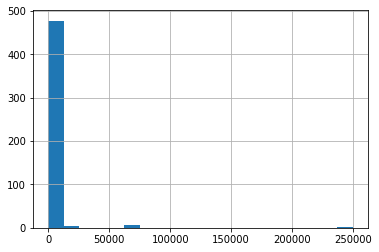

In [337]:
# show the distribution of NaNs
na_pattern = azdias_go.isna().sum().hist(bins=20)
plt.show()

We want to use Principal Component Analysis (PCA) for dimensionality reduction

In [338]:
# First, use SimpleImputer to remove NaNs.
imp = SimpleImputer(strategy='constant', fill_value=0, verbose=3)
azdias_imp = imp.fit_transform(azdias_go)

In [339]:
# Apply feature scaling to the general population demographics data.
scaler = StandardScaler()
azdias_scaled = scaler.fit_transform(azdias_imp) 

In [340]:
# create a dataframe from the transformed (imputer/scaler) demographic data
df = pd.DataFrame(azdias_scaled)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 644077 entries, 0 to 644076
Columns: 489 entries, 0 to 488
dtypes: float64(489)
memory usage: 2.3 GB


In [341]:
# Apply PCA to the data.

def pca_results(pca):
    
    # NOTE: This function was obtained from Udacity's course notes/lab work
    '''
    Create a DataFrame of the PCA results
    Includes dimension feature weights and explained variance
    Visualizes the results
    '''
    # Dimension indexing
    dimensions = dimensions = ['Dimension {}'.format(i) for i in range(1,len(pca.components_)+1)]

    # PCA components
    components = pd.DataFrame(np.round(pca.components_, 4), columns = azdias_go.keys())
    components.index = dimensions

    # PCA explained variance
    ratios = pca.explained_variance_ratio_.reshape(len(pca.components_), 1)
    variance_ratios = pd.DataFrame(np.round(ratios, 4), columns = ['Explained Variance'])
    variance_ratios.index = dimensions
       
    # Return a concatenated DataFrame
    
    return pd.concat([variance_ratios, components], axis = 1)

In [342]:
# us a scree plot
def scree_plot(pca, k):
    '''
    Creates a scree plot associated with the principal components 
    
    INPUT: 
    pca - the result of instantiation of PCA in scikit learn
    k - the fraction of components to display (e.g., 0.5)
            
    OUTPUT:
            None
    '''
    num_components=len(pca.explained_variance_ratio_)*k
    ind = np.arange(num_components)
    vals = pca.explained_variance_ratio_
    vals_plot = vals[:len(ind)]
   
 
    plt.figure(figsize=(20, 6))
    ax = plt.subplot(111)
   
    cumvals = np.cumsum(vals_plot)
    
    ax.bar(ind, vals_plot)
    ax.plot(ind, cumvals)
    for i in range(int(num_components)):
    
        ax.annotate(r"%s%%" % ((str(vals[i]*100)[:4])), (ind[i]+0.2, vals[i]+0.02), va="bottom", ha="center", fontsize=12, rotation=90)
    ax.xaxis.set_tick_params(width=0)
    ax.yaxis.set_tick_params(width=2, length=12)
 
    ax.set_xlabel("Principal Component")
    ax.set_ylabel("Variance Explained")
    plt.title('Explained Variance Per Principal Component')

In [343]:
# Try a range of components 
for n in range(200, 251, 10):
    pca = PCA(n)
    X_pca = pca.fit_transform(azdias_scaled)
    comp_check = pca_results(pca)
  
    print("Using {} components, we can explain {: .2f}% of the variability in the original data.".format(comp_check.shape[0], comp_check['Explained Variance'].sum()*100)) 

Using 200 components, we can explain  82.31% of the variability in the original data.
Using 210 components, we can explain  83.93% of the variability in the original data.
Using 220 components, we can explain  85.55% of the variability in the original data.
Using 230 components, we can explain  87.01% of the variability in the original data.
Using 240 components, we can explain  88.42% of the variability in the original data.
Using 250 components, we can explain  89.76% of the variability in the original data.


In [344]:
# go for 220 components (55% reduction in dimensionality)

n_components = 220
pca = PCA(n_components)
X_pca = pca.fit_transform(azdias_scaled)
comp_check = pca_results(pca)
print("The {} components used in the following explain {: 2f}% of the variability in the original data.".format(comp_check.shape[0], comp_check['Explained Variance'].sum()*100)) 

The 220 components used in the following explain  85.550000% of the variability in the original data.


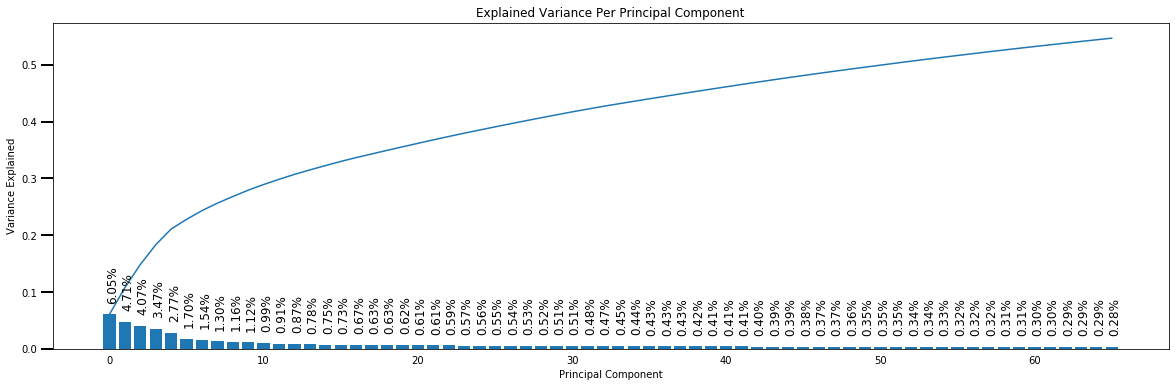

In [345]:
scree_plot(pca, 0.3)

### Discussion

We ran the PCA analysis for 200 to 250 components in increments of 10.  The lower end of the range explained 82.3% of the variability in the original data, and the upper end of the range 89.8%. We settled for 220 components, which reduces the dimensionality by more than half (from 498 tp 220), considering that a gain of 4.2% in accuracy did not seem to justify the lesser dimensionality reduction--and thus the higher complexity--of working with 250 components.
With 220 pca components, the first 12 components explain 30% of the total variability, as seen on the chart above.

### Interpret principal components

In [346]:
# Map weights for the first principal component to corresponding feature names

def compare_comp(n):
    weights_sorted_a = comp_check.iloc[n,1:].sort_values().head(10)
    weights_sorted_d = comp_check.iloc[n,1:].sort_values(ascending=False).head(10)
    print(f"\nWeights for Principal Component {n+1}")
    print(f"Positive \n{weights_sorted_d} \n")
    print(f"Negative \n{weights_sorted_a} \n")

def map_pca(n, pca):
    # Dimension indexing
    dimensions = dimensions = ['Dimension {}'.format(i) for i in range(1,len(pca.components_)+1)]

    # PCA components
    components = pd.DataFrame(np.round(pca.components_, 4), columns = azdias_go.keys())
    components.index = dimensions
    
    # Create a bar plot visualization
    weights_sorted_a = comp_check.iloc[n,1:].sort_values().head(10)
    weights_sorted_d = comp_check.iloc[n,1:].sort_values(ascending=False).head(10)
   
    df = pd.concat([weights_sorted_d , weights_sorted_a.sort_values(ascending=False)] )
    fig, ax = plt.subplots(figsize = (20,8))
    df.plot(ax=ax, kind='bar')
    ax.set_ylabel("Feature Weights")
    ax.set_xticklabels(df.index)
    ax.axhline(y=0)
    
    ax.text(0, ax.get_ylim()[0]/5 +0, "LARGEST POSITIVE WEIGHTS", fontsize=16)
    ax.text(ax.get_xlim()[1]/2+0.25, ax.get_ylim()[1]/5 + 0, "LARGEST NEGATIVE WEIGHTS", fontsize=16)
    
    print(ax.get_xlim()[0],ax.get_xlim()[1], ax.get_ylim()[0],ax.get_ylim()[1])
    

-0.5 19.5 -0.14654499999999998 0.153645

Weights for Principal Component 1
Positive 
MOBI_REGIO             0.1400
KBA13_ANTG1            0.1334
PLZ8_ANTG1             0.1323
KBA05_ANTG1            0.1299
MOBI_RASTER            0.1277
KBA05_GBZ              0.1232
LP_STATUS_GROB_4.0     0.1203
KBA13_AUTOQUOTE        0.1196
FINANZ_MINIMALIST      0.1087
LP_LEBENSPHASE_FEIN    0.1085
Name: Dimension 1, dtype: float64 

Negative 
PLZ8_ANTG3           -0.1329
KBA13_ANTG3          -0.1325
KBA13_ANTG4          -0.1288
KBA13_BAUMAX         -0.1285
PLZ8_ANTG4           -0.1275
PLZ8_BAUMAX          -0.1266
HH_EINKOMMEN_SCORE   -0.1254
LP_STATUS_GROB_1.0   -0.1203
EWDICHTE             -0.1087
ORTSGR_KLS9          -0.1069
Name: Dimension 1, dtype: float64 



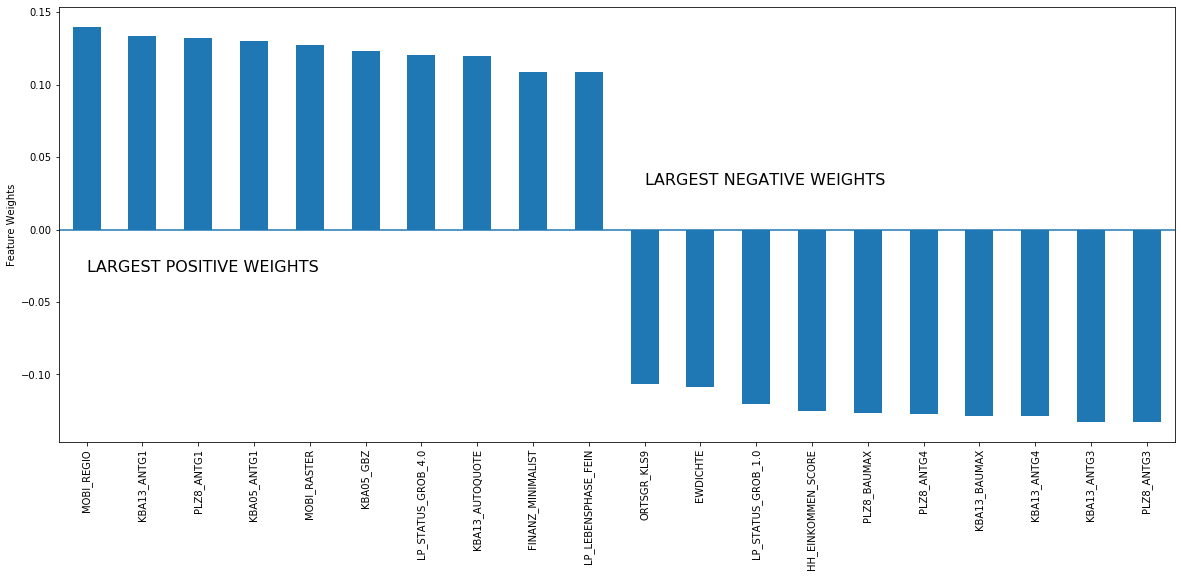

In [347]:
map_pca(0, pca)
compare_comp(0)

-0.5 19.5 -0.07773 0.19573

Weights for Principal Component 2
Positive 
KBA05_SEG6        0.1833
KBA05_KRSOBER     0.1621
KBA05_KRSVAN      0.1583
KBA05_KRSZUL      0.1567
KBA05_SEG8        0.1509
KBA05_KRSKLEIN    0.1458
KBA05_SEG7        0.1446
KBA05_SEG9        0.1433
KBA05_MOTOR       0.1412
KBA05_MOD8        0.1408
Name: Dimension 2, dtype: float64 

Negative 
PR_J_gen             -0.0653
ONLINE_AFFINITAET    -0.0637
FINANZ_SPARER        -0.0618
FINANZ_ANLEGER       -0.0614
CJT_TYP_1            -0.0587
CJT_TYP_2            -0.0558
D19_GESAMT_ANZ_24    -0.0540
D19_GESAMT_ANZ_12    -0.0501
D19_VERSAND_ANZ_24   -0.0480
SEMIO_PFLICHT        -0.0468
Name: Dimension 2, dtype: float64 



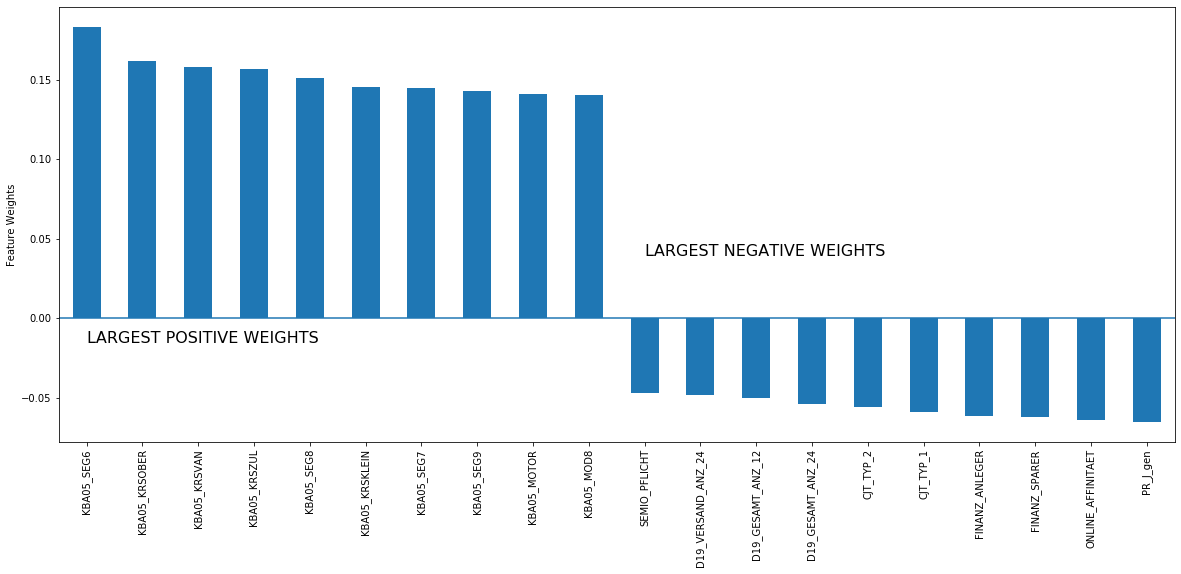

In [348]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.

map_pca(1, pca)
compare_comp(1)

-0.5 19.5 -0.157965 0.171265

Weights for Principal Component 3
Positive 
CJT_TYP_2                0.1563
PR_J_gen                 0.1551
CJT_TYP_1                0.1533
FINANZ_SPARER            0.1525
ONLINE_AFFINITAET        0.1403
FINANZ_UNAUFFAELLIGER    0.1289
SEMIO_PFLICHT            0.1233
FINANZ_ANLEGER           0.1212
SEMIO_TRADV              0.1201
D19_GESAMT_ANZ_24        0.1149
Name: Dimension 3, dtype: float64 

Negative 
CJT_TYP_5                 -0.1430
FINANZ_VORSORGER          -0.1418
CJT_TYP_4                 -0.1392
CJT_TYP_3                 -0.1390
CJT_TYP_6                 -0.1365
KOMBIALTER                -0.1329
ALTERSKATEGORIE_GROB      -0.1309
ZABEOTYP_3                -0.1206
CJT_KATALOGNUTZER         -0.1188
D19_GESAMT_ONLINE_DATUM   -0.1125
Name: Dimension 3, dtype: float64 



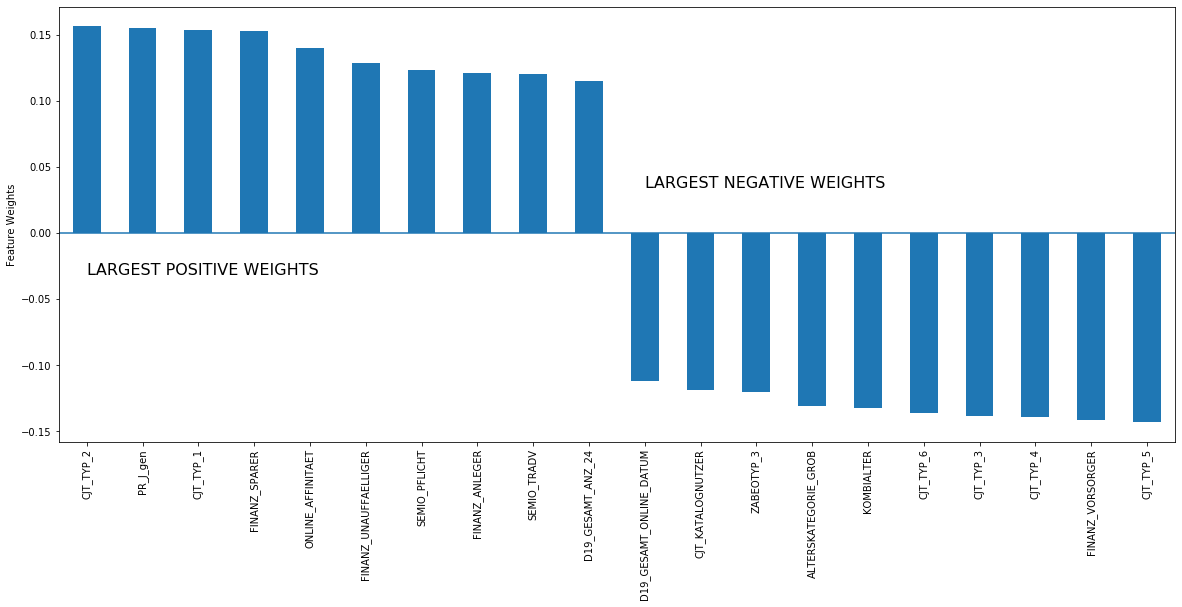

In [349]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.

map_pca(2, pca)
compare_comp(2)


We find it difficult to interpret the components individually, as the same feature might be weighed positively in one component and negatively in another.  See for example FINANZ_ANLEGER which appears among the top positive weights in component 3 and among the top negative weights in component 2.  Rather, we can look at the story they tell as a group.  As such, they emphasize:

  * Financial status (FINANZ_, HH_EINKOMMEN_SCORE)
  * Residental housing types (PLZ8_)
  * Advertising preferences or sensitivity (CJT_)
  * Car ownership chacracteristics (KBA05_, KBA13_)
  
These observations would invite the company to profile existing customers along these dimensions and target new customers accordingly.


We will now identify clusters for the general population and compare them with clusters for  the customer population

## Clustering for the general population

In [350]:
# Over a number of different cluster counts...

scores = []
test_range = np.arange(5, 26, 5)
for n in test_range:
    n_clusters = n
    # run k-means clustering on the data and...
    kmean = KMeans(n_clusters)
    cluster_labels = kmean.fit_predict(X_pca)

    # compute the average within-cluster distances.
    score = np.abs(kmean.score(X_pca))
    print(f"for {n_clusters} clusters, the score = {score}")
    scores.append(score)

for 5 clusters, the score = 230957762.34979287
for 10 clusters, the score = 219600253.6539975
for 15 clusters, the score = 213969752.9154332
for 20 clusters, the score = 210422669.87518063
for 25 clusters, the score = 207404798.44981736


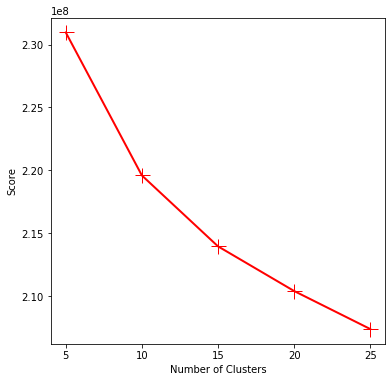

In [351]:
# plot the results
fig, ax = plt.subplots(figsize=(6,6))

line = plt.plot(test_range, scores)
plt.setp(line, 'color', 'r', 'linewidth', 2.0, marker='+', ms=15.0)
ax.set_ylabel("Score")
ax.set_xlabel('Number of Clusters')
ax.set_xticks(test_range)
plt.show()

The above figure shows the change in within-cluster distance as a function of the number of clusters.  We settled for 20 clusters, as the processing time becomes too oerous beyond that point.

In [352]:
# Re-fit the k-means model with the 20 clusters 
n_clusters = 20

kmean = KMeans(n_clusters, random_state=42)
cluster_labels = kmean.fit_predict(X_pca)
score = np.abs(kmean.score(X_pca))  
print(f"for {n_clusters} clusters, the score = {score}")

for 20 clusters, the score = 210333561.7192371


Data Distribution in clusters

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]

Number of points in each cluster 
[41333 42611 46170  9069 26122 21049 23866 26306 24878 33838 40031 52427
 43844 53788 50606 46488  1609 13177 23317 23548] 

Relative number of points in each cluster
 [0.064174   0.06615824 0.07168398 0.01408061 0.04055726 0.03268088
 0.03705458 0.04084294 0.03862582 0.0525372  0.06215251 0.08139865
 0.06807261 0.08351175 0.07857135 0.07217771 0.00249815 0.02045873
 0.03620219 0.03656085] 


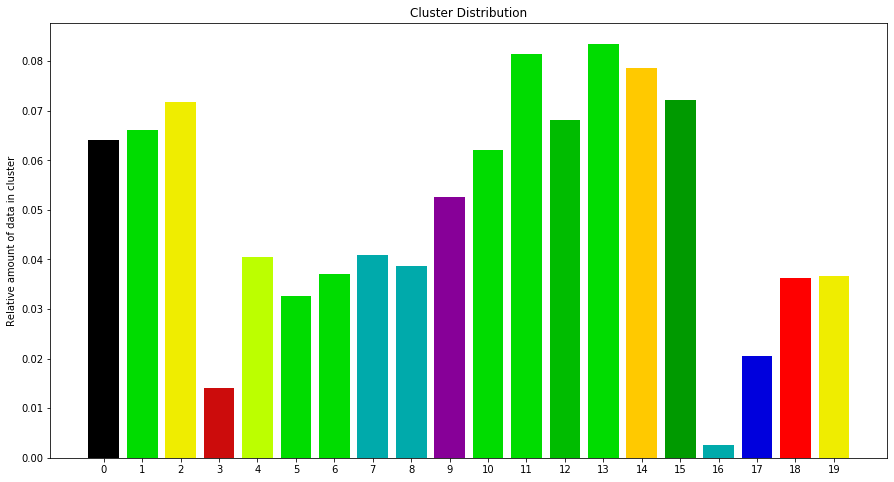

In [353]:
#calculate proportion in each cluster
import matplotlib.cm as cm

unique, cluster_data_count = np.unique(cluster_labels, return_counts=True)
cluster_data_ratio = cluster_data_count/X_pca.shape[0]
print("Data Distribution in clusters\n")
print(unique)
print(f"\nNumber of points in each cluster \n{cluster_data_count} ")
print(f"\nRelative number of points in each cluster\n {cluster_data_ratio} ")

def cluster_distribution (unique, data, labels, n):
    fig, ax = plt.subplots(figsize=(15,8))
    colors = cm.nipy_spectral(labels.astype(float) / n)
    plt.bar(unique, data, color=colors)
    ax.set_ylabel('Relative amount of data in cluster')
    ax.set_title('Cluster Distribution')
    ax.set_xticks(unique)
    plt.show()
    
cluster_distribution(unique, cluster_data_ratio, cluster_labels, n_clusters)

### Follow the same process with customer data

In [354]:
# Using the cleaned dataset
customers_imp = imp.fit_transform(customers_go)

#apply feature scaling
customers_scaled = scaler.fit_transform(customers_imp)

# apply PCA to customer data:
X_pca_customers = pca.transform(customers_scaled)

# clustering customer data
cluster_labels_customers = kmean.predict(X_pca_customers)

Data Distribution in clusters(customer data) 

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]

Number of points in each cluster 
[ 3691 10868 10381   933  4129  1709   461  6997  1504  2648  8982  5066
 23649 16708 14043 24712    10 46261   982  7918] 

Relative number of points in each cluster
 [1.92588650e-02 5.67069480e-02 5.41658840e-02 4.86819861e-03
 2.15442573e-02 8.91720410e-03 2.40540146e-03 3.65088807e-02
 7.84755703e-03 1.38167095e-02 4.68661950e-02 2.64333271e-02
 1.23395529e-01 8.71788450e-02 7.32734331e-02 1.28942041e-01
 5.21779058e-05 2.41380210e-01 5.12387035e-03 4.13144658e-02] 


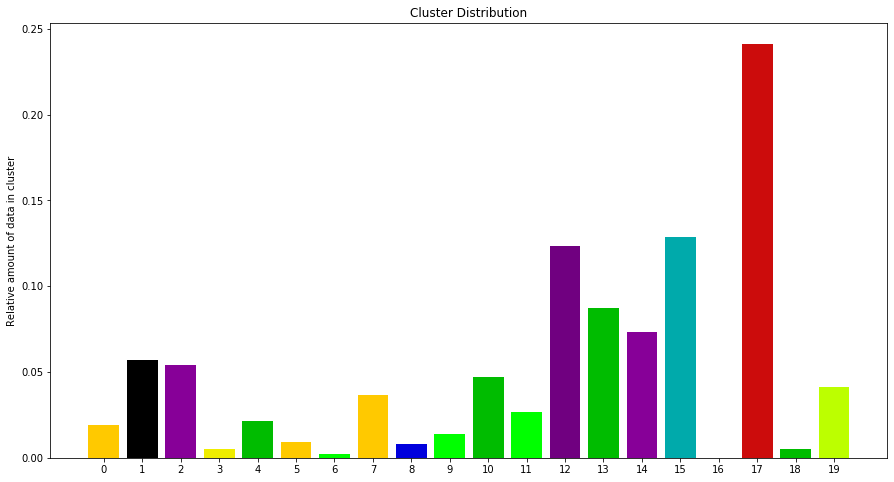

In [355]:
#calculate proportion in each cluster

#print(np.unique(cluster_labels_customers))
unique, cluster_data_count_customers = np.unique(cluster_labels_customers, return_counts=True)
cluster_data_ratio_customers = cluster_data_count_customers/X_pca_customers.shape[0]
print("Data Distribution in clusters(customer data) \n")
print(unique)
print(f"\nNumber of points in each cluster \n{cluster_data_count_customers} ")
print(f"\nRelative number of points in each cluster\n {cluster_data_ratio_customers} ")

cluster_distribution(unique, cluster_data_ratio_customers, cluster_labels_customers, n_clusters)

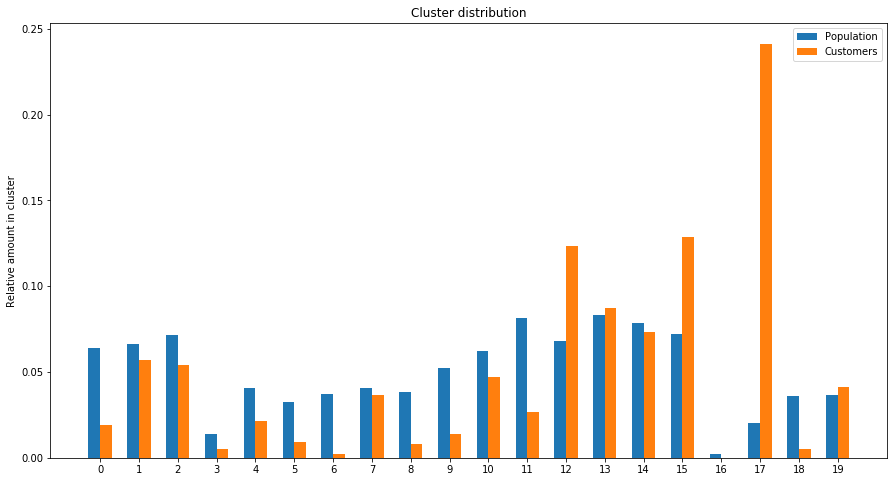

In [356]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.

x = np.arange(len(unique)) 
width = 0.3  # the width of the bars
fig, ax = plt.subplots(figsize=(15,8))
pop = ax.bar(x - width/2, cluster_data_ratio, width, label='Population')
cust = ax.bar(x + width/2, cluster_data_ratio_customers, width, label='Customers')

ax.set_ylabel('Relative amount in cluster')
ax.set_title('Cluster distribution')
ax.set_xticks(unique)
ax.set_xticklabels(unique)
ax.legend();

### Identify clusters w/ largest differences

We need to automate this because the cluster ids (but not the magnitudes) can differ between identical runs

In [357]:
def calc_cluster_diffs (cluster1, cluster2, n_clusters=n_clusters):
    
    cluster_diff = np.subtract(cluster1, cluster2)
    #print(cluster_diff)

    # keep track of cluster order before sorting
    dict_diff = {cluster_diff[i]:i for i in range (0, n_clusters)}
    #print("\nDictionary", dict_diff)

    cluster_diff = np.sort(cluster_diff)[::-1]
    print("Cluster differences")
    print(cluster_diff)
    maxdiff = cluster_diff[0]
    mindiff = cluster_diff[-1]
    print("\nlargest positive difference: {} (cluster {})".format(maxdiff,dict_diff[maxdiff]))
    print("\nlargest negative difference: {} (cluster {})".format(mindiff,dict_diff[mindiff]))
    
    diff_ids = []
    for c in cluster_diff:
        diff_ids.append(dict_diff[c])
    #print(diff_ids)
    
    return diff_ids, dict_diff

In [358]:
diff_az, dict_az = calc_cluster_diffs(cluster_data_ratio_customers, cluster_data_ratio)
print('\nClusters ranked in terms of population differences (cust vs az):')
print(diff_az)

Cluster differences
[ 0.22092148  0.05676434  0.05532292  0.00475362  0.00366709 -0.00244597
 -0.00433406 -0.00529792 -0.00921242 -0.00945129 -0.01528631 -0.01751809
 -0.01901301 -0.02376367 -0.03077826 -0.03107832 -0.03464917 -0.03872049
 -0.04491514 -0.05496533]

largest positive difference: 0.2209214759926441 (cluster 17)

largest negative difference: -0.05496532557358414 (cluster 11)

Clusters ranked in terms of population differences (cust vs az):
[17, 15, 12, 19, 13, 16, 7, 14, 3, 1, 10, 2, 4, 5, 8, 18, 6, 9, 0, 11]


Find what kinds of people are part of a cluster that is overrepresented in the customer data compared to the general population

In [359]:
# Inverse the results
pca_to_scaler = pca.inverse_transform(kmean.cluster_centers_)
scaler_to_original = scaler.inverse_transform(pca_to_scaler)
print(scaler_to_original.shape)
print(pca_to_scaler.shape)

#Get details for a specific cluster

def cluster_data (cluster_id):
    print("Cluster number: ", cluster_id)
    print ("\nWeights after scaling")
    print(pca_to_scaler[cluster_id,:])
    print ("\nWeights before scaling")
    print(scaler_to_original[cluster_id,:])

    # Associate data to attributes
    cluster_info = pd.DataFrame(data=pca_to_scaler[cluster_id,:], index=azdias_go.columns, columns=['weight'])
    
    # sort the values
    cluster_info = cluster_info.sort_values(by='weight', axis=0, ascending=False)
    print("\nLargest Positive Weights")
    print(cluster_info.head(10))
    print("\nLargest Negative Weights")
    print(cluster_info.tail(10).sort_values(by='weight'))
    
    #cluster_info.plot(kind='bar', figsize=(20,10), legend=False, title = "Cluster " + str(cluster_id))


(20, 489)
(20, 489)


In [360]:
# Show data for the cluster with the largest positive difference
cluster_id = diff_az[0]
print ("data for the cluster with the largest positive difference")
cluster_data(cluster_id)

data for the cluster with the largest positive difference
Cluster number:  17

Weights after scaling
[ 2.44799275e-01 -4.61829366e-01  1.53548080e-01 -1.03479138e-02
 -9.60028497e-02 -1.35394130e-01 -6.35133306e-02  8.67668692e-02
 -1.62316183e-01  7.65151649e-01  6.04382977e-01  5.65166174e-01
  3.03584168e-01  4.24581141e-01 -3.15495980e-01 -2.27220887e-01
 -1.65711327e-01 -2.02161108e-01  2.90819102e-01 -2.94180609e-01
 -1.50139831e-01 -1.72750281e-01  1.11509317e-01  2.59366476e-01
 -1.69941947e-01 -2.14234847e-01 -2.94856008e-01 -3.19056332e-01
 -2.94506580e-01 -6.26370514e-02 -3.89745195e-01 -9.63503212e-02
 -3.05179358e-01 -1.66046288e-01 -2.16744875e-01 -2.70633812e-01
 -4.47519761e-01 -4.81235085e-01  5.21633573e-01  2.98590039e-01
  4.97496267e-01 -4.11285980e-01 -3.08713568e-01 -3.47039131e-01
 -2.57967870e-01  4.60355286e-01 -2.86228564e-01 -1.16011931e-01
 -3.92469588e-01 -3.49658386e-01 -1.63863696e-01 -9.36240160e-02
 -2.07533672e-01 -1.64182492e-01 -2.42540103e-01 -3.47

                       weight
VERS_TYP            -3.009501
HEALTH_TYP          -2.853799
NATIONALITAET_KZ_1  -2.328067
RT_UEBERGROESSE     -1.466108
PR_J_gen            -0.965038
SEMIO_VERT          -0.944040
LP_LEBENSPHASE_FEIN -0.737651
FINANZ_MINIMALIST   -0.672220
LP_LEBENSPHASE_GROB -0.672111
SHOPPER_TYP_3.0     -0.669248


In [361]:
# Repeat the process for the cluster with the second largest positive difference
cluster_id = diff_az[1]
print ("data for the cluster with the second largest positive difference")
cluster_data(cluster_id)

data for the cluster with the second largest positive difference
Cluster number:  15

Weights after scaling
[-4.71789407e-01 -3.86238139e-01 -4.35080242e-01 -1.03948045e-01
 -2.53121833e-01  1.27334157e-02 -3.42468231e-02 -1.27219222e-01
 -5.71974679e-02  4.36757470e-01 -9.54763522e-01 -9.78756807e-01
  7.97716681e-01  8.96180456e-01  9.14758022e-01  8.21694670e-01
 -2.17004031e-01 -2.58232417e-01  2.84176320e-01 -2.55143227e-01
 -2.33993619e-01 -5.23011287e-02  1.06283458e-01  2.66950654e-01
 -2.01457814e-01 -1.58269897e-01  6.63789013e-02 -1.10810328e-01
  2.78789563e-02 -3.25738760e-02  1.54495967e-01 -1.14461190e-01
 -2.10647518e-01 -2.11035882e-03 -2.56645858e-01 -6.33759775e-02
 -3.98858907e-01 -3.78858464e-01  2.23175185e-01  6.75822246e-02
  3.49999859e-01 -3.39532259e-01  2.05580155e-01 -6.03914418e-02
 -1.40467973e-01 -5.43834584e-02  1.15657689e-01 -4.74991511e-02
 -3.02260123e-05  2.98586894e-01  2.19142445e-02 -1.62169114e-01
  2.77162644e-01  2.35507897e-01 -2.52915936e-0

**Discussion**

The features with the largest weights in the cluster where the difference between the general population and customers is the greatest show the importance of the financial variables--both investment style (FININANZ_) and economic means ( LP_STATUS_).

This observation is confirmed by looking at the next cluster in term of differences.  In this cluster we also note the weights given to the features associated with advertising (CJT_TYP_) but we do not have enough information to interpret this further.



##  Part 2: Supervised Learning Model
Now that you've found which parts of the population are more likely to be customers of the mail-order company, it's time to build a prediction model. Each of the rows in the "MAILOUT" data files represents an individual that was targeted for a mailout campaign. Ideally, we should be able to use the demographic information from each individual to decide whether or not it will be worth it to include that person in the campaign.
The "MAILOUT" data has been split into two approximately equal parts, each with almost 43 000 data rows. In this part, you can verify your model with the "TRAIN" partition, which includes a column, "RESPONSE", that states whether or not a person became a customer of the company following the campaign. In the next part, you'll need to create predictions on the "TEST" partition, where the "RESPONSE" column has been withheld.

In [362]:
#mailout_train = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TRAIN.csv', sep=';')
# read the cleaned dataset
mailout_train_go_ = pd.read_csv('mailout_train_go.csv', low_memory=False)
mailout_train_go_.drop(['Unnamed: 0'], axis=1, inplace=True)
mailout_train_go_.head()

,AKT_DAT_KL,ALTER_HH,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_TITEL,ARBEIT,BALLRAUM,CJT_KATALOGNUTZER,...,ZABEOTYP_1,ZABEOTYP_2,ZABEOTYP_3,ZABEOTYP_4,ZABEOTYP_5,ZABEOTYP_6,CAMEO_wealth,CAMEO_life,PR_J_mvt,PR_J_gen
0,1.0,8.0,15.0,0.0,0.0,1.0,0.0,3.0,5.0,5.0,...,0,0,1,0,0,0,34.0,34.0,0,1
1,4.0,13.0,1.0,0.0,0.0,2.0,0.0,2.0,5.0,2.0,...,1,0,0,0,0,0,32.0,32.0,0,4
2,1.0,9.0,0.0,NaN,0.0,0.0,0.0,4.0,1.0,5.0,...,0,0,1,0,0,0,14.0,14.0,1,1
3,1.0,6.0,4.0,0.0,0.0,2.0,0.0,4.0,2.0,5.0,...,0,0,1,0,0,0,14.0,14.0,1,1
4,1.0,9.0,53.0,0.0,0.0,1.0,0.0,3.0,4.0,5.0,...,0,0,1,0,0,0,41.0,41.0,0,2


In [363]:
print(mailout_train_go_.shape)


(42962, 490)


In [364]:
mailout_train_go_['RESPONSE'].describe()

count    42962.000000
mean         0.012383
std          0.110589
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: RESPONSE, dtype: float64

In [365]:
mailout_train_go_['RESPONSE'].sum()

532

**Discussion**

Wow! 

The number of positive responses for this data set is 532, i.e., 1.2%. We cannot call this a failed campaign without knowing the expectations, but from a practical standpoint, this dataset as is does not give us much material to work with. It seems futile to use supervised training techniques to predict the response when a naive estimate that over 98% will fail to respond is probably accurate. (We assume that the percentage of positive responses is roughly the same in the other/test half of the mailout dataset.) Could these poor results be explained?

As a preliminary step, we will cluster the `mailout_train` data as we did for the other two datasets and compare the mail recipients with the company's existing customers to see what we can learn. The method is the same:

  * clean the data (done)
  * use PCA for dimensionality reduction
  * cluster with KMeans
  

In [366]:
print(customers_go.shape)

(191652, 489)


In [367]:
delta1 = np.setdiff1d(list(customers_go.columns), list(mailout_train_go_.columns))
print(delta1)

[]


In [368]:
delta2 = np.setdiff1d(list(mailout_train_go_.columns), list(customers_go.columns))
print(delta2)

['RESPONSE']


In [369]:
# we drop RESPONSE for now
mailout_train_go = mailout_train_go_.drop(['RESPONSE'], axis=1)
mailout_train_go.shape

(42962, 489)

### Clustering

In [370]:
# Using the cleaned dataset
mailout_train_imp = imp.fit_transform(mailout_train_go)

#apply feature scaling
mailout_train_scaled = scaler.fit_transform(mailout_train_imp)

# apply PCA to mailout data:
X_pca_mailout_train = pca.transform(mailout_train_scaled)

# clustering mailout data
cluster_labels_mailout_train = kmean.predict(X_pca_mailout_train)

In [371]:
X_pca_mailout_train.shape

(42962, 220)

Data Distribution in clusters(mailout_train data) 

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]

Number of points in each cluster 
[ 925 2485 3406  383 1146 1132  292 1322 1383  825 2188 1257 4060 4474
 3490 4229   67 7025 1078 1795] 

Relative number of points in each cluster
 [0.02153065 0.05784181 0.07927936 0.00891485 0.02667474 0.02634887
 0.0067967  0.03077138 0.03219124 0.01920302 0.05092873 0.02925841
 0.09450212 0.10413854 0.08123458 0.09843583 0.00155952 0.1635166
 0.02509194 0.04178111] 


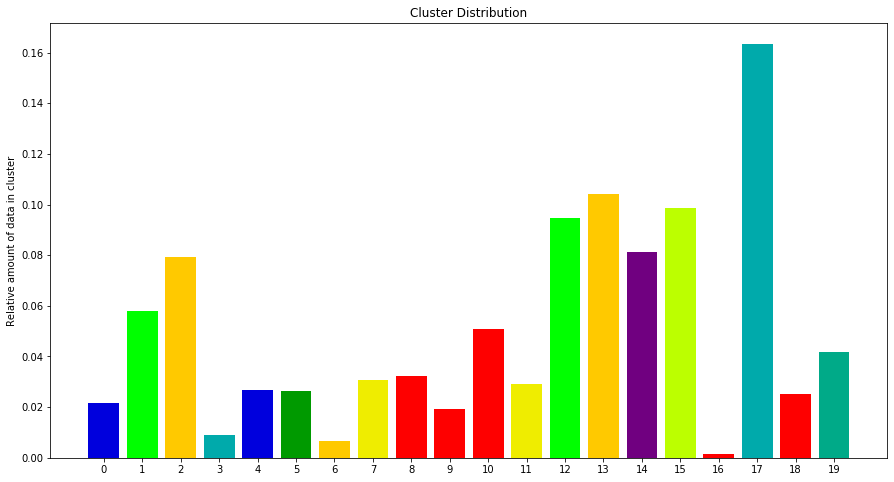

In [372]:
# calculate the proportion in each cluster

#print(np.unique(cluster_labels_customers))
unique, cluster_data_count_mailout_train = np.unique(cluster_labels_mailout_train, return_counts=True)
cluster_data_ratio_mailout_train = cluster_data_count_mailout_train/X_pca_mailout_train.shape[0]
print("Data Distribution in clusters(mailout_train data) \n")
print(unique)
print(f"\nNumber of points in each cluster \n{cluster_data_count_mailout_train} ")
print(f"\nRelative number of points in each cluster\n {cluster_data_ratio_mailout_train} ")

cluster_distribution(unique, cluster_data_ratio_mailout_train, cluster_labels_mailout_train, n_clusters)

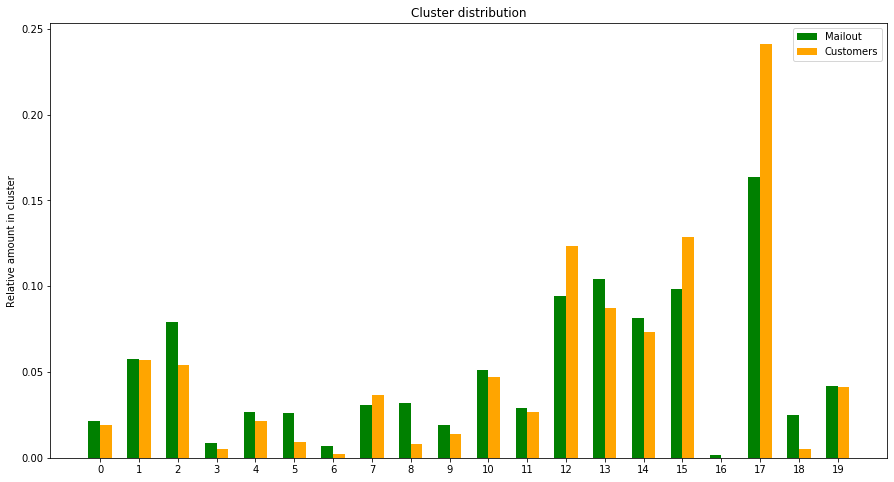

In [373]:
# Compare the proportion of data in each cluster for the mailout data to the
# proportion of data in each cluster for the customers.

x = np.arange(len(unique)) 
width = 0.3  # the width of the bars
fig, ax = plt.subplots(figsize=(15,8))
#pop = ax.bar(x - width/2, cluster_data_ratio, width, label='Population')
mailout = ax.bar(x - width/2, cluster_data_ratio_mailout_train, width, label='Mailout', color='green')
cust = ax.bar(x + width/2, cluster_data_ratio_customers, width, label='Customers',color='orange')

ax.set_ylabel('Relative amount in cluster')
ax.set_title('Cluster distribution')
ax.set_xticks(unique)
ax.set_xticklabels(unique)
ax.legend();

**Discussion**

The above figure compares the cluster distributions for `customers` and `mailout_train`. Interestingly, if we compare this display with the cluster distribution of population vs customers shown earlier, the `mailout_train` data are half-way, so to speak, between the population characteristics and the customer characteristics.


In [374]:
# identify clusters w/ largest differences
diff_mail, dict_mail = calc_cluster_diffs(cluster_data_ratio_customers, cluster_data_ratio_mailout_train)
print('\nClusters ranked in terms of population differences (cust vs mailout):')
print(diff_mail)

Cluster differences
[ 0.07786361  0.03050621  0.02889341  0.0057375  -0.00046664 -0.00113487
 -0.00150734 -0.00227179 -0.00282509 -0.00404666 -0.00406253 -0.0043913
 -0.00513048 -0.00538631 -0.00796115 -0.0169597  -0.01743166 -0.01996807
 -0.02434368 -0.02511348]

largest positive difference: 0.07786361390225702 (cluster 17)

largest negative difference: -0.025113479160059904 (cluster 2)

Clusters ranked in terms of population differences (cust vs mailout):
[17, 15, 12, 7, 19, 1, 16, 0, 11, 3, 10, 6, 4, 9, 14, 13, 5, 18, 8, 2]


In [375]:
print(len(cluster_labels_customers))

191652


###  Methodology 

We tried two approaches to supervised learning:  In the first approach, we augmented the original `mailout_train` dataset with records from the `customers` dataset, while assuming that these additional records would elicit a RESPONSE = 1.  In the second approach, we engineered a new RESPONSE column with values weighed according to the record's location in the cluster distribution.

**Strategy 1**

We decided to augment `mailout_train` with records from `customers` in order to get a better balance between succes and failure in the training dataset. Specifically, we will select records from the three clusters found to differ the most from the general population (`azdias`)--or, conversely, to be the most representative of customers' characteristics. In the cluster-distribution figure above (unsupervised learning), the records would come from clusters 17, 15, and 12. We will pick systematically a sufficient number of records to increase the size of `mailout_train` by 30%. For these records, we assign a value of 1 to the RESPONSE feature. Admittedly, it is highly optimistic to assume that existing customers would necessarily respond to a mail offer, so we will keep this limitation in mind.

In [376]:
# pick the points in selected clusters
subset = []
target = diff_az[:3]
print("\nCollecting records from clusters: {}".format(target))

# collect the sample points in the selected clusters
for item in target:
    for i in range (0, len(cluster_labels_customers)):
        if item == cluster_labels_customers[i]:
            subset.append(i)
#print(subset[:10])
print("Total number of records available: {}".format(len(subset)))
    


Total number of records available: 94622


In [377]:
# We want to add ~ 30% more points to the existing training dataset
n_add = int(mailout_train_go.shape[0]*0.3)
print(n_add)

# pick every k point in the subset to achieve desired amount
k = int(len(subset)/n_add)
print(k)
sub_customers = []
for i in range(0, len(subset), k):
    sub_customers.append(subset[i])

print("Total number of records to be added: {}".format(len(sub_customers)))

# check
print("that is {: .2f}%".format(len(sub_customers)/mailout_train_go.shape[0]*100))

12888
7
Total number of records to be added: 13518
that is  31.47%


In [378]:
# make a dataframe of these samples
cust_samples = customers_go.loc[sub_customers,:]
print(cust_samples.shape)
cust_samples.loc[:,'RESPONSE'] = 1
print(cust_samples.shape)

mailout_train_plus_ = pd.concat([mailout_train_go_, cust_samples], axis=0)
print(mailout_train_plus_.shape)

(13518, 489)
(13518, 490)
(56480, 490)


Now, we will try training with the mailout dataset, first in its original configuration and then augmented with records from `customers`.

In [379]:
# Use RandomForest classifier
def fit_random_forest_classifier(X, y):
    '''
    INPUT: 
    X : n (records) x m (features)
    y : list of dimension n
    OUTPUT:
    accuracy, ROC score, y_predicted
    '''
    #First split training and testing data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    #try a simple model to see how it works
    clf = RandomForestClassifier(n_estimators=100, max_depth=None)

    # fit
    clf.fit(X_train, y_train)

    # predict
    y_preds = clf.predict(X_test)

    # score
    acc = accuracy_score(y_test, y_preds)
    # skip if y not binary
    try:
        roc = roc_auc_score(y_test, y_preds)
    except:
        roc = -1
    #print(acc, roc)
    
    return acc, roc, y_preds

In [380]:
# using the original mailout dataset
y = mailout_train_go_['RESPONSE']
acc, roc, y_preds = fit_random_forest_classifier(X_pca_mailout_train, y)
print("accuracy: {} ROC: {}".format(acc, roc))

accuracy: 0.98591877109275 ROC: 0.5


In [381]:
print(y_preds.sum())
mailout_train_plus_.shape

0


(56480, 490)

In [382]:
# using the augmented mailout dataset
y = mailout_train_plus_['RESPONSE']

# transform new set with PCA
mailout_train_plus = mailout_train_plus_.drop(['RESPONSE'], axis=1)
mailout_train_imp = imp.fit_transform(mailout_train_plus)

# apply feature scaling
mailout_train_scaled = scaler.fit_transform(mailout_train_imp)

# apply PCA to mailout data
X_pca_mailout_train_plus = pca.transform(mailout_train_scaled)

# clustering mailout data
cluster_labels_mailout_train_plus = kmean.predict(X_pca_mailout_train_plus)

In [383]:
X_pca_mailout_train_plus.shape

(56480, 220)

In [384]:
y.sum()

14050

In [385]:
acc, roc, y_preds = fit_random_forest_classifier(X_pca_mailout_train_plus, y)
print("accuracy: {} ROC: {}".format(acc, roc))
print(y_preds[:50])
print(y_preds.sum())

accuracy: 0.7887747875354107 ROC: 0.6506981401718244
[0 0 0 1 0 0 1 0 1 0 1 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0
 0 0 0 1 0 0 0 0 0 0 0 0 0]
1648


We will now try to find optimum parameters using `GridSearchCV` for RandomForest and AdaBoost classifiers.

In [386]:
# try parameter search
def fit_random_forest_opt(X, y):
    '''
    INPUT: 
    X : n (records) x m (features)
    y : list of dimension n
    OUTPUT:
    accuracy, ROC score, y_predicted
    '''
    #First create training and testing data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    clf_rf = RandomForestClassifier()
    
    # Set up the hyperparameter search
    n_features = X_test.shape[1]
    param_dist = {"max_depth": [3, None],
              "n_estimators": [100, 200],
              }

    # Run a search over the hyperparameters
    grid_search = GridSearchCV(clf_rf, param_grid=param_dist)
    
    # Fit the model on the training data
    grid_search.fit(X_train, y_train)
    
    # Make predictions on the test data
    rf_preds = grid_search.best_estimator_.predict(X_test)

    #score
    acc = accuracy_score(y_test, rf_preds)
    roc = roc_auc_score(y_test, rf_preds)
    
    print(grid_search.best_estimator_)

    return acc, roc, rf_preds

In [387]:
rf_acc, rf_roc, rf_preds = fit_random_forest_opt(X_pca_mailout_train_plus, y)
print("accuracy: {} ROC: {}".format(rf_acc, rf_roc))
print(rf_preds.sum())

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)
accuracy: 0.7872698300283286 ROC: 0.6481883337146496
1639


In [388]:
def fit_AdaBoost_opt(X, y):
    '''
    INPUT: 
    X : n (records) x m (features)
    y : list of dimension n
    OUTPUT:
    accuracy, ROC score, y_predicted
    '''
    #First create training and testing data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # define clsssifier
    clf_ada = AdaBoostClassifier()
    
    # Set up the hyperparameter search
    param_dist = {'n_estimators':[100, 200],'learning_rate':[0.05, 0.5]}

    # Run a search over the hyperparameters
    grid_search = GridSearchCV(clf_ada, param_grid=param_dist)
    
    # Fit the model on the training data
    grid_search.fit(X_train, y_train)
    
    # Make predictions on the test data
    ada_preds = grid_search.best_estimator_.predict(X_test)

    #score
    acc = accuracy_score(y_test, ada_preds)
    roc = roc_auc_score(y_test, ada_preds)
    
    print(grid_search.best_estimator_)

    return acc, roc, ada_preds

In [389]:
ada_acc, ada_roc, ada_preds = fit_AdaBoost_opt(X_pca_mailout_train_plus, y)
print("accuracy: {} ROC: {}".format(ada_acc, ada_roc))
print(ada_preds.sum())

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=0.5,
                   n_estimators=200, random_state=None)
accuracy: 0.8128541076487252 ROC: 0.7189350005139479
2278


NOTE:  We also tried SVC but the computation time was prohibitive with the hardware at our disposal.

In [390]:
def fit_SVC_opt(X, y):
    '''
    INPUT: 
    X : n (records) x m (features)
    y : list of dimension n
    OUTPUT:
    accuracy, ROC score
    '''
    #First create training and testing data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # define classifier
    clf_svc = SVC()
    
    # Set up the hyperparameter search
    param_dist = {'kernel':['rbf'],'degree':[1, 2]}

    # Run a search over the hyperparameters
    grid_search = GridSearchCV(clf_svc, param_grid=param_dist)
    
    # Fit the model on the training data
    grid_search.fit(X_train, y_train)
    
    # Make predictions on the test data
    svc_preds = grid_search.best_estimator_.predict(X_test)

    #score
    acc = accuracy_score(y_test, svc_preds)
    roc = roc_auc_score(y_test, svc_preds)
    
    print(grid_search.best_estimator_)

    return acc, roc

In [391]:
#svc_acc, svc_roc = fit_SVC_opt(X_pca_mailout_train_plus, y)
#print(svc_acc, svc_roc)

In [392]:
def compare_rf_ada(X, y):
    '''
    INPUT: 
    X : n (records) x m (features)
    y : list of dimension n
    OUTPUT:
    ROC score and predictions for AdaBoost and RandomForest Classifiers
    '''
    #First create training and testing data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # fit random forest with best parameters
    clf_rf = RandomForestClassifier(n_estimators=100)

    # fit
    clf_rf.fit(X_train, y_train)

    #predict
    preds_rf = clf_rf.predict(X_test)

    #score
    acc_rf = accuracy_score(y_test, preds_rf)
    # skip if y non-binary
    try:
        roc_rf = roc_auc_score(y_test, preds_rf)
    except:
        roc_rf = -1
    print("RandomForest Classifier:")
    print("Accuracy: {}; ROC: {}".format(acc_rf, roc_rf))
    
     # fit AdaBoost with best parameters
    clf_ada = AdaBoostClassifier(n_estimators=200, learning_rate=0.5)

    #fit
    clf_ada.fit(X_train, y_train)

    #predict
    preds_ada = clf_ada.predict(X_test)

    #score. 
    acc_ada = accuracy_score(y_test, preds_ada)
    # skip if y non-binary
    try:
        roc_ada = roc_auc_score(y_test, preds_ada)
    except:
        roc_ada = -1
    print("AdaBoost Classifier:")
    print("Accuracy: {}; ROC: {}".format(acc_ada, roc_ada))
    
    if roc_rf and roc_ada >= 0:
        disp_ada = plot_roc_curve(clf_ada, X_test, y_test)
        disp_rf = plot_roc_curve(clf_rf, X_test, y_test, ax=disp_ada.ax_)
        disp_rf.figure_.suptitle("ROC curve comparison")
    
    return clf_rf, clf_ada, preds_rf, preds_ada

RandomForest Classifier:
Accuracy: 0.7870042492917847; ROC: 0.6482416350837403
AdaBoost Classifier:
Accuracy: 0.8128541076487252; ROC: 0.7189350005139479


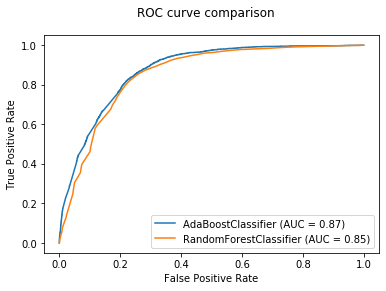

In [393]:
clf_rf, clf_ada, preds_rf, preds_ada = compare_rf_ada(X_pca_mailout_train_plus, y)

**Discussion**

We trained the augmented `mailout_train` dataset with both RandomForest and AdaBoost classifiers using the PCA components as the feature set, and the "best" parameters from the previous optimization.  As seen from the ROC curve shown above RandomForest and AdaBoost gave virtually identical results.

**Strategy 2**

The idea is to engineer a synthetic RESPONSE column (`RESPONSE2`) wherein the values depend on the cluster to which a record belongs.  In the previous cluster analysis, we noted that some clusters contain relatively more customers than the general population, and vice versa.  Thus, the contention here is that a positive response to the marketing campaign is more likely in clusters with a relatively larger amount of customers.

Let dH be the difference (in relative terms) between customers and a reference population and m a positive integer.  The metric created to measure `RESPONSE2` is equal to 0.5 + mdH. If dH is > 0, the probability of a positive response is higher; if dH is < 0, the probability of a positive response is lower.

In [394]:
# calculate new y

# reverse the dictionary
reverse_dictionary = {v:k for k,v in dict_mail.items()}
n_mail = mailout_train_go.shape[0]
# initialize 
response2 = n_mail*[0]

m = 2
for i in range (0, n_mail):
    cli = cluster_labels_mailout_train[i]
    response2[i]= 0.5 + m*reverse_dictionary[cli]    

In [396]:
# check
print(response2[:20])
print(len(cluster_labels_mailout_train))
print(mailout_train_go.shape[0])

[0.48973904297328985, 0.5577868224922161, 0.5610124275446708, 0.5114750026421243, 0.48973904297328985, 0.48922738566642276, 0.5610124275446708, 0.4840777074034882, 0.6557272278045141, 0.6557272278045141, 0.6557272278045141, 0.4840777074034882, 0.5577868224922161, 0.5610124275446708, 0.4977302686282209, 0.4660806079072258, 0.6557272278045141, 0.5114750026421243, 0.6557272278045141, 0.4513126365226124]
42962
42962


In [397]:
print(X_pca_mailout_train.shape)

# It appears that sklearn classifiers expect y as integers or strings.  Converting to integers.
response2I = []
for item in response2:
    response2I.append(int(item*1000))
# check
print(response2I[:10])

(42962, 220)
[489, 557, 561, 511, 489, 489, 561, 484, 655, 655]


In [398]:
mailout_train_go.loc[:, 'RESPONSE2'] = response2I
#try training with this new y
y = mailout_train_go['RESPONSE2']
clf_rf2, clf_ada2, preds_rf2, preds_ada2 = compare_rf_ada(X_pca_mailout_train, y)

RandomForest Classifier:
Accuracy: 0.8217153497032468; ROC: -1
AdaBoost Classifier:
Accuracy: 0.4938903758873502; ROC: -1


In [399]:
print('Predictions')
print("RandomForest: max {}; min {}; mean {: .2f}".format(preds_rf2.max(), preds_rf2.min(), preds_rf2.mean()))
print("AdaBoost: max {}; min {}; mean{: .2f} ".format(preds_ada2.max(), preds_ada2.min(), preds_ada2.mean()))
      

Predictions
RandomForest: max 655; min 449; mean  525.75
AdaBoost: max 655; min 449; mean 521.26 


## Evaluation

At this point we cannot tell if either of the two models proposed above is a good predictor of RESPONSE.  But according to the score obtained in the Kaggle competition, neither one is good. We can identify ways to improve the work done so far, but this probably won't impove significantly the Kaggle score.  There must be a better way to quantify the probability of RESPONSE --and we don't know what it is.

As a possible improvement to the models above, we could try a more extensive search of the optimum parameters for AdaBoost and RandomForest.  We could also try using SVC as a classifier, but as mentioned earlier this is impractical when solving a problem of this size on a standard laptop.  

A wild idea would be to forget supervised learning altogether and simply filter out "manually" the records in `mailout` most similar to the customers' profile.  Practically, this means focusing on a subset of the original 366 features, specifically those measuring financial characteristics, residential housing, car ownership--variables found important in PCA and the unsupervised learning analysis--and then picking the records that are above a threshold to be determined.  We did not test this approach because the assignment was to do supervised learning, but it might be worth a try.

More problematic is the effectiveness of any mailout campaign.  Ironically, the better we became at fighting spam, the better we also became at filtering out any email solicitation.  Thus, a mailout campaign may not be the best way to expand the customer base, even for a mail-order business. Web advertising or even an old-fashioned printed brochure might bring better results.

## Part 3: Kaggle Competition

Now that you've created a model to predict which individuals are most likely to respond to a mailout campaign, it's time to test that model in competition through Kaggle. If you click on the link here, you'll be taken to the competition page where, if you have a Kaggle account, you can enter. If you're one of the top performers, you may have the chance to be contacted by a hiring manager from Arvato or Bertelsmann for an interview!
Your entry to the competition should be a CSV file with two columns. The first column should be a copy of "LNR", which acts as an ID number for each individual in the "TEST" partition. The second column, "RESPONSE", should be some measure of how likely each individual became a customer – this might not be a straightforward probability. As you should have found in Part 2, there is a large output class imbalance, where most individuals did not respond to the mailout. Thus, predicting individual classes and using accuracy does not seem to be an appropriate performance evaluation method. Instead, the competition will be using AUC to evaluate performance. The exact values of the "RESPONSE" column do not matter as much: only that the higher values try to capture as many of the actual customers as possible, early in the ROC curve sweep.

In [400]:
#mailout_test = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TEST.csv', sep=';')
# read the cleaned dataset
mailout_test_go = pd.read_csv('mailout_test_go.csv', low_memory=False)
mailout_test_go.drop(['Unnamed: 0'], axis=1, inplace=True)
mailout_test_go.head()

,AKT_DAT_KL,ALTER_HH,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_TITEL,ARBEIT,BALLRAUM,CJT_KATALOGNUTZER,...,ZABEOTYP_1,ZABEOTYP_2,ZABEOTYP_3,ZABEOTYP_4,ZABEOTYP_5,ZABEOTYP_6,CAMEO_wealth,CAMEO_life,PR_J_mvt,PR_J_gen
0,1.0,7.0,2.0,0.0,0.0,2.0,0.0,3.0,6.0,5.0,...,0,0,1,0,0,0,5.0,3.0,1,1
1,1.0,0.0,20.0,0.0,0.0,1.0,0.0,4.0,7.0,5.0,...,0,0,1,0,0,0,3.0,1.0,0,3
2,9.0,16.0,2.0,0.0,0.0,4.0,0.0,4.0,1.0,5.0,...,0,0,1,0,0,0,2.0,1.0,1,3
3,7.0,0.0,1.0,0.0,0.0,0.0,0.0,4.0,1.0,5.0,...,0,0,1,0,0,0,5.0,3.0,0,3
4,1.0,21.0,1.0,0.0,0.0,4.0,0.0,3.0,6.0,1.0,...,0,0,0,1,0,0,3.0,1.0,0,4


In [401]:
print(mailout_test_go.shape)

(42833, 489)


In [402]:
mailout_test_go.describe()

,AKT_DAT_KL,ALTER_HH,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_TITEL,ARBEIT,BALLRAUM,CJT_KATALOGNUTZER,...,ZABEOTYP_1,ZABEOTYP_2,ZABEOTYP_3,ZABEOTYP_4,ZABEOTYP_5,ZABEOTYP_6,CAMEO_wealth,CAMEO_life,PR_J_mvt,PR_J_gen
count,35944.000000,35944.000000,35206.000000,34687.000000,35944.000000,35944.000000,35944.000000,35050.000000,35192.000000,42255.000000,...,42833.000000,42833.000000,42833.000000,42833.000000,42833.000000,42833.000000,35086.000000,35086.000000,42833.000000,42833.000000
mean,1.518890,10.239511,6.749986,0.045666,0.090752,2.023481,0.010934,3.039658,4.286827,3.884085,...,0.196321,0.035463,0.624589,0.098032,0.006677,0.038919,22.766574,22.847546,0.280835,2.430743
std,1.737441,6.109680,14.839779,0.339404,0.400107,1.358137,0.112969,1.044242,2.185527,1.451494,...,0.397218,0.184950,0.484235,0.297361,0.081441,0.193403,18.184833,18.096136,0.449412,1.843263
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000
25%,1.000000,8.000000,1.000000,0.000000,0.000000,1.000000,0.000000,2.000000,2.000000,3.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,4.000000,0.000000,1.000000
50%,1.000000,10.000000,2.000000,0.000000,0.000000,2.000000,0.000000,3.000000,5.000000,5.000000,...,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,22.000000,22.000000,0.000000,2.000000
75%,1.000000,15.000000,7.000000,0.000000,0.000000,3.000000,0.000000,4.000000,6.000000,5.000000,...,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,41.000000,41.000000,1.000000,3.000000
max,9.000000,21.000000,379.000000,20.000000,7.000000,14.000000,3.000000,9.000000,7.000000,5.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,55.000000,55.000000,1.000000,7.000000


We use the same dimensionality reduction with this dataset

In [403]:
# transform new set with PCA
mailout_test_imp = imp.fit_transform(mailout_test_go)

#apply feature scaling
mailout_test_scaled = scaler.fit_transform(mailout_test_imp)

# apply PCA to mailout data:
X_pca_mailout_test = pca.transform(mailout_test_scaled)

**Strategy 1** 

We use AdaBoost to predict the RESPONSE for this dataset

In [404]:
preds_kag = clf_ada.predict(X_pca_mailout_test)

In [405]:
len(preds_kag)

42833

In [406]:
preds_kag.sum()

2294

In [407]:
ids = pd.read_csv('mailout_test_ids.csv')
ids.drop(['Unnamed: 0'], axis=1, inplace=True)
ids.head()

,LNR
0,1754
1,1770
2,1465
3,1470
4,1478


In [408]:
ids.loc[:,'RESPONSE'] = preds_kag
ids.to_csv('df_response.csv')

**Strategy 2** 

For the second set of predictions, we will use the RandomForest clssifier


In [409]:
preds_kag2I = clf_rf2.predict(X_pca_mailout_test)

In [410]:
#Revert to the float values
preds_kag2 = []
for item in preds_kag2I:
    preds_kag2.append(item/1000)

In [411]:
ids.loc[:,'RESPONSE2'] = preds_kag2
ids.to_csv('df_response2.csv')

The score for Strategy 1 = 0.49845 and for Strategy 2 = 0.51389.  

Small parameter changes to these strategies could not improve these disappointing results.